## imports

In [1]:
import numpy as np
from numpy import linalg as l
import scipy.integrate as integrate
import matplotlib.pyplot as plt

## functions

In [2]:
def initial_state(a):
    uy = np.linspace(-np.sqrt(a), np.sqrt(a), 1001)
    y = np.sign(uy) * uy ** 2

    Y, Y_ = np.meshgrid(y, y, indexing='ij')

    step_y1 = y - np.roll(y, 1)
    step_y2 = np.roll(y, -1) - y
    step_y1[0] = step_y2[-1] = 0
    step_y = (step_y1 + step_y2) / 2 #trapezoidal rule

    u = np.tanh(y)
    dev2u = - 2 * np.tanh(y) / (np.cosh(y) ** 2)

    min_Y = np.minimum(Y, Y_)
    max_Y = np.maximum(Y, Y_)

    return y, u, dev2u, step_y, min_Y, max_Y

In [3]:
def exact_solution(y):
    psi_exact = -1 / np.cosh(y) / 2
    zeta_exact = 1 / (np.cosh(y) ** 3)
    return psi_exact, zeta_exact

In [4]:
def count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y):
    green = - (np.exp(- k * max_Y) - np.exp(- k * (2 * a - max_Y))) * \
              (np.exp(k * min_Y) - np.exp(- k * (2 * a + min_Y))) / \
              (1 - np.exp(- 4 * k * a)) / 2 / k
    
    kernel = np.diag(u) - (np.tile(dev2u, (len(dev2u), 1)).T * #np.tile() for manual 
                           green *                             #broadcasting
                           np.tile(step_y, (len(step_y), 1)))
    
    val, vect = l.eig(kernel)
    return val, vect

In [5]:
def plot_eigen(val, vect, k):
    fig, ax = plt.subplots(figsize=(11, 3))
    
    try: 
        k = k.round(5)
    except:
        k = k
    
    plt.subplot(1, 2, 1)
    plt.scatter(np.real(val), np.imag(val), s=8, alpha=0.7, label=f'k = {k}')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.legend(fontsize=8)

    plt.subplot(1, 2, 2)
    vect = vect.T
    idx_complexval1 = np.imag(val).argmax()
    idx_complexval2 = np.imag(val).argmin()
    plt.plot(y, np.real(vect[idx_complexval1]), label=f'Re(EigVec) \n with C={val[idx_complexval1].round(2)}')
    plt.plot(y, np.imag(vect[idx_complexval1]), label=f'Im(EigVec) \n with C={val[idx_complexval1].round(2)}')
    
    plt.legend(fontsize=8)
    
    return plt.show()

In [6]:
def plot_difference(vals, vect, k):
    eps = 1e-15
    vect = vect.T
    idx_complexval = np.imag(vals).argmax()
    zeta_vect = vect[idx_complexval]
    zeta_vect = zeta_vect / zeta_vect.max()
    psi_vect = zeta_vect * (u + eps - vals[idx_complexval]) / (dev2u + eps)
    zeta_diff = (zeta_vect - zeta_exact).mean()
    psi_diff = (psi_vect - psi_exact).mean()
    
    fig, ax = plt.subplots(figsize=(11, 3))

    plt.subplot(1, 2, 1)
    plt.plot(y, np.real(zeta_vect), label=f'EigVec with C={vals[idx_complexval].round(2)}')
    plt.plot(y, zeta_exact, label=f'exact solution with \n diff = {zeta_diff.round(4)}')
    plt.xlabel('y')
    plt.ylabel('zeta(y)')
    #plt.ylim(-2.1, 1.1)
    plt.legend(loc='upper right', fontsize=8)

    plt.subplot(1, 2, 2)
    idx_complexval = np.imag(vals).argmax()
    plt.plot(y, np.real(psi_vect), label=f'psi with C={vals[idx_complexval].round(2)}')
    plt.plot(y, psi_exact, label=f'exact solution with \n diff = {psi_diff.round(4)}')
    plt.xlabel('y')
    plt.ylabel('psi(y)')
    plt.legend(loc='upper right', fontsize=8)

## initial state

In [7]:
a = 5
y, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
psi_exact, zeta_exact = exact_solution(y)

## stability criteria research

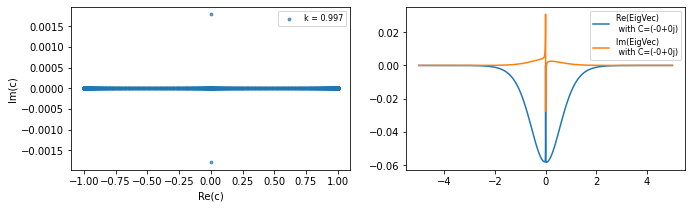

In [8]:
k = 0.997
vals, vect = count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y)
plot_eigen(vals, vect, k)

In [9]:
imag_vals = []
for k in np.linspace(0.995, 1., 50):
    vals, vect = count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y)
    imag_vals.append((k, np.imag(vals).max()))
    #plot_eigen(vals, vect, k)

In [10]:
imag_vals = np.array(imag_vals)
k_crit = imag_vals.T[0, imag_vals.T[1].argmin()]

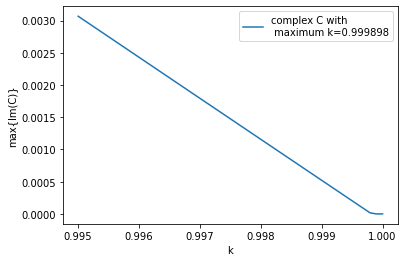

In [11]:
plt.plot(imag_vals.T[0], imag_vals.T[1], label=f'complex C with \n maximum k={k_crit.round(6)}')
plt.xlabel('k')
plt.ylabel('max{Im(C)}')
plt.legend()

## eigenvectors and analytical solution

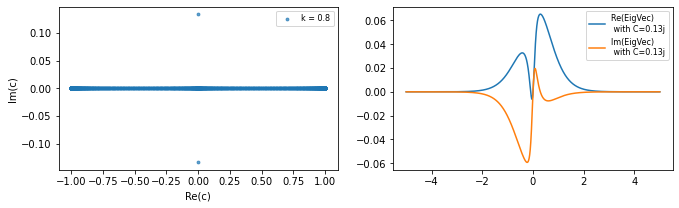

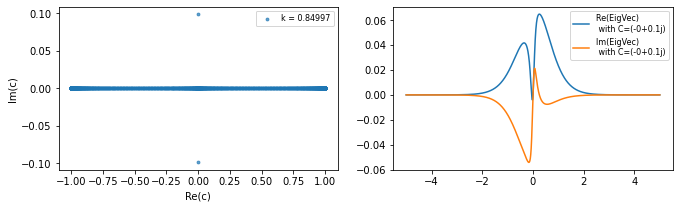

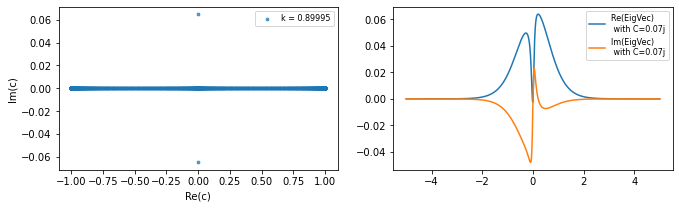

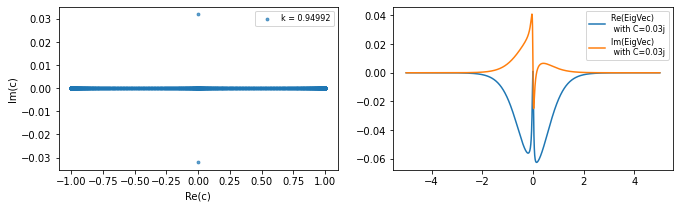

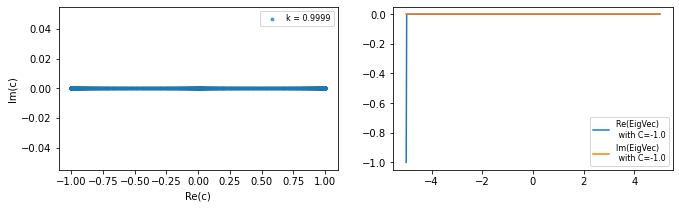

In [12]:
for k in np.linspace(0.8, k_crit, 5):
    vals, vect = count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y)
    plot_eigen(vals, vect, k)

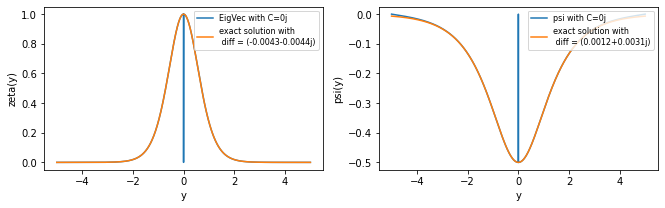

In [13]:
vals, vect = count_eigen(0.9997, a, max_Y, u, min_Y, dev2u, step_y)
plot_difference(vals, vect, 0.9997)

## stability depending on parameter a

In [14]:
a_array = np.linspace(0.5, 2, 25)
k_array = np.linspace(0.1, 0.5, 5)
A, K = np.meshgrid(a_array, k_array, indexing='ij')
complex_vals = np.zeros_like(A)

for i in range(len(a_array)):
    for j in range(len(k_array)):
        a = a_array[i]
        k = k_array[j]
        y, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
        vals, vect = count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y)
        complex_val = np.imag(vals).max()
        complex_vals[i,j] = complex_val

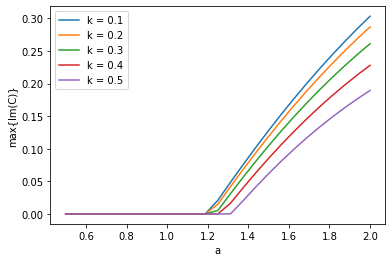

In [15]:
for i in range(len(k_array)):
    plt.plot(a_array, complex_vals[:, i], label=f'k = {k_array[i].round(2)}')
plt.xlabel('a')
plt.ylabel('max{Im(C)}')
plt.legend()

In [16]:
zeros_number = np.isclose(complex_vals, 0).sum(axis=1)
argmax = zeros_number.argmax()
a_0_idx = -1
while argmax == 0:
    zeros_number = np.roll(zeros_number,-1)
    argmax = zeros_number.argmax()
    a_0_idx = a_0_idx + 1
    a_0_idx

In [17]:
a_0 = a_array[a_0_idx]

In [18]:
a_0

1.1875